# Energy Market Dashboard

This notebook documents the development of a systematic trading strategy for **US Natural Gas Futures (`NG=F`)**.

We hypothesize that integrating **external fundamental data**, specifically **Weather/Temperature** at the physical delivery hub, can provide a predictive "edge" that pure technical analysis misses.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import yfinance as yf
import matplotlib.pyplot as plt

## Market data

For this project, we will try to analyse and develop a strategy for trading energy commodities. For now we will focus on Natural Gas futures (NG=F).
We'll use Yahoo Finance to retrieve historical data as well as the latest data. 

In [2]:
ticker = "NG=F"
start = "2020-01-01"

df = yf.download(ticker, start=start, progress=False)
df.head()

C:\Users\maxen\AppData\Local\Temp\ipykernel_22920\3421266544.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,NG=F,NG=F,NG=F,NG=F,NG=F
Date,,,,,
2020-01-02,2.122,2.188,2.116,2.184,164570
2020-01-03,2.130,2.163,2.083,2.129,144669
2020-01-06,2.135,2.173,2.099,2.112,154678
2020-01-07,2.162,2.178,2.102,2.149,163006
2020-01-08,2.141,2.185,2.115,2.153,242559


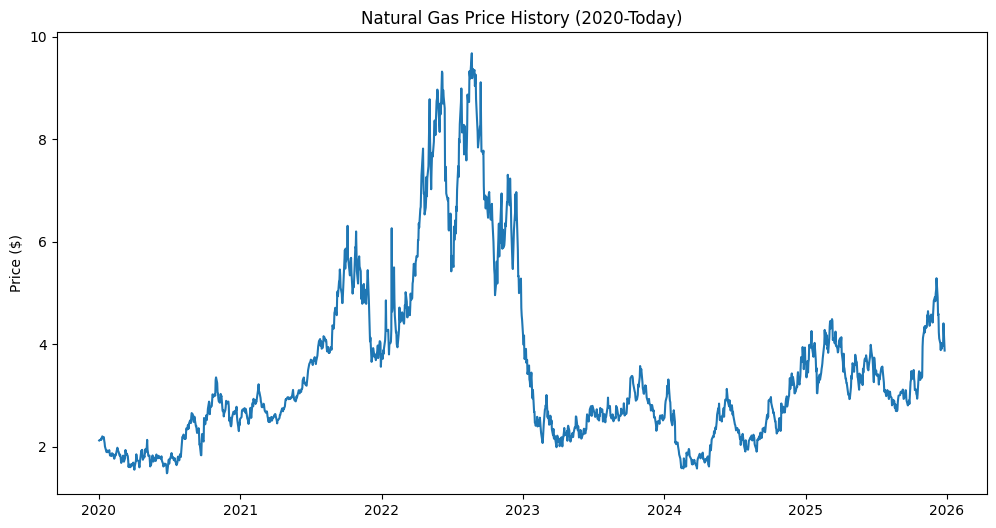

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("Natural Gas Price History (2020-Today)")
plt.ylabel("Price ($)")
plt.show()

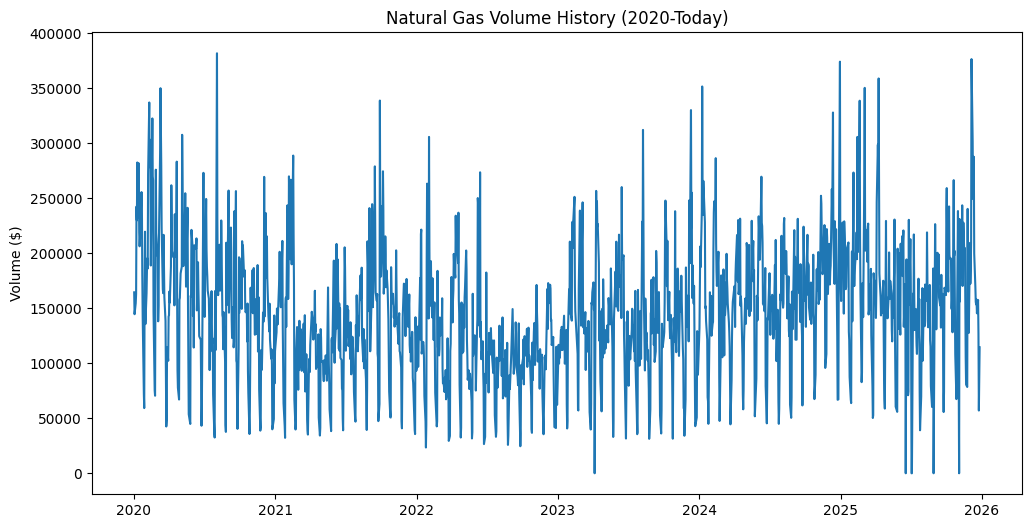

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['Volume'])
plt.title("Natural Gas Volume History (2020-Today)")
plt.ylabel("Volume ($)")
plt.show()

## Weather data

To make this project a bit more interesting, we'll use an additional source of data to see if it helps us get an edge. Specifically, we'll fetch weather data from the Open Meteo API, which has a very generous free tier and doesn't even require an API key. 

For simplicity, I only look at the temperature of a single location, Henry Hub, as a proxy. I chose Henry Hub because it is the physical delivery point of Natural Gas (NG=F). In a production environment, I would implement a Population-Weighted Degree Day index covering the Northeast and Midwest to capture residential heating demand more accurately.

In [5]:
import requests

# Henry Hub GPS coordinates found online
LAT = 29.89
LON = -92.06

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": "2020-01-01",
    "end_date": "2025-12-10",
    "daily": "temperature_2m_mean",
    "timezone": "auto"
}

response = requests.get(url, params=params)
data = response.json()

# Convert the weather data to DataFrame
weather_df = pd.DataFrame({
    'date': data['daily']['time'],
    'temp': data['daily']['temperature_2m_mean']
})
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.set_index('date', inplace=True)

In [6]:
weather_df.head()

,temp
date,
2020-01-01,10.8
2020-01-02,19.9
2020-01-03,16.0
2020-01-04,11.9
2020-01-05,12.2


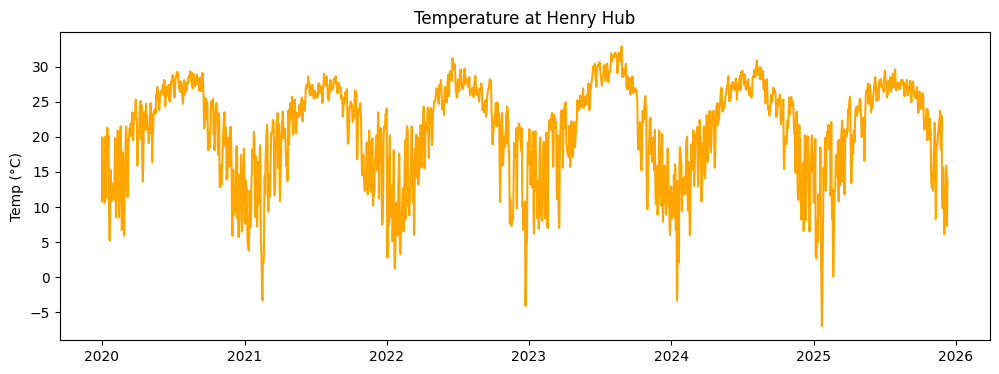

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(weather_df['temp'], color='orange')
plt.title("Temperature at Henry Hub")
plt.ylabel("Temp (°C)")
plt.show()

We can make the hypothesis that Gas price and weather data are related

In [8]:
# We need to fix the MultiIndex otherwise we can't merge tables
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [9]:
# Let's merge both data sources
merged = df[['Close']].join(weather_df, how='inner')
merged.rename(columns={'Close': 'Price', 'temp': 'Temp'}, inplace=True)

C:\Users\maxen\AppData\Local\Temp\ipykernel_22920\673808215.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


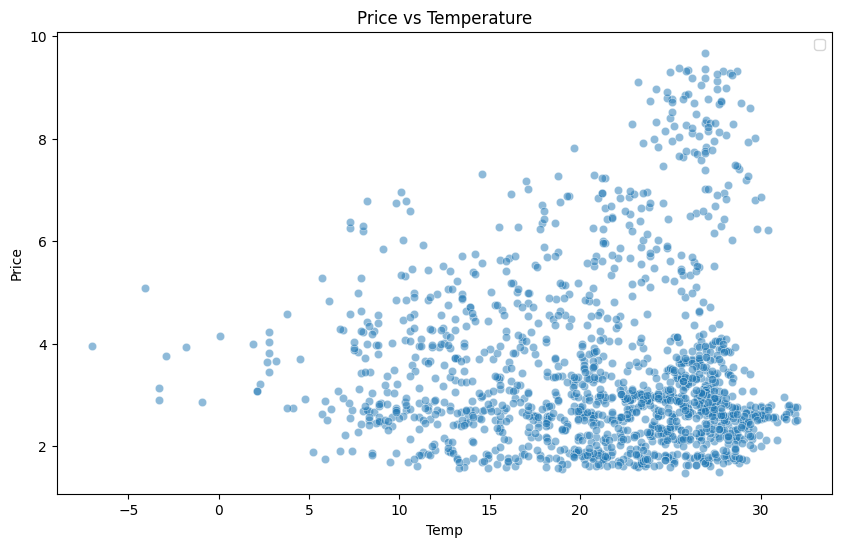

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='Temp', y='Price', alpha=0.5)
plt.title("Price vs Temperature")
plt.legend()
plt.show()

I was expecting another type of correlation, maybe showing that both very low and very high temperatures drive the price higher, meaning a scatterplot that resembles the shape of a smile. But that's not what we got there. Maybe my assumption was incorrect, but there was also the war in Ukraine, which disrupted the market a lot, as Europeans stopped buying Russian gas and bought US gas instead. Let's actually calculate correlation, both linear and a polynomial of order 2, to see if there is a hidden "smile" shaped correlation. 

Linear Correlation (Pearson): 0.03
Rank Correlation (Spearman): -0.05


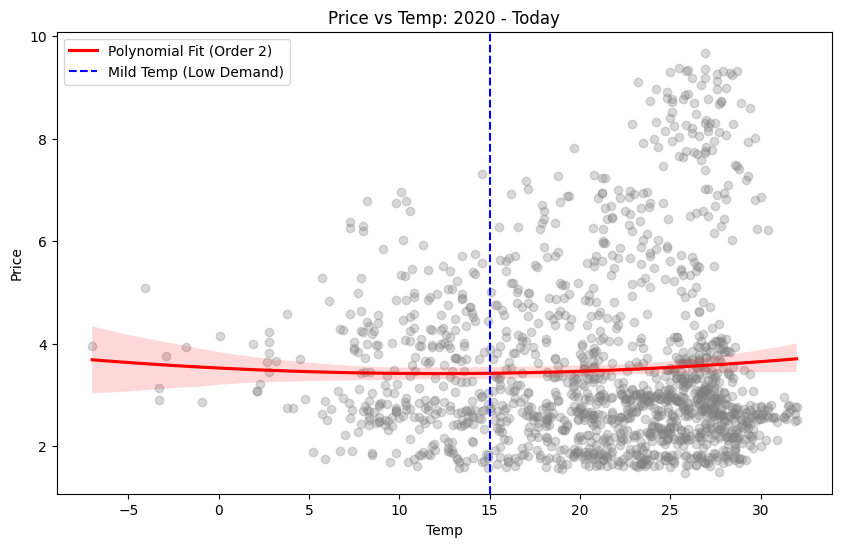

In [11]:
# 1. Calculate Correlations
# Pearson = Linear (Does it go up in a straight line?)
# Spearman = Monotonic (Does it go up generally, even if curved?)
corr_pearson = merged['Price'].corr(merged['Temp'], method='pearson')
corr_spearman = merged['Price'].corr(merged['Temp'], method='spearman')

print(f"Linear Correlation (Pearson): {corr_pearson:.2f}")
print(f"Rank Correlation (Spearman): {corr_spearman:.2f}")

# 2. Visualize with a Polynomial Fit (Order 2 = Parabola/U-Shape)
plt.figure(figsize=(10, 6))

# scatter_kws={'alpha':0.3} makes points transparent so we see density
# order=2 tells Seaborn to try to fit a curve (U-shape), not a straight line
sns.regplot(data=merged, x='Temp', y='Price', order=2, 
            scatter_kws={'alpha':0.3, 'color':'gray'}, 
            line_kws={'color':'red', 'label': 'Polynomial Fit (Order 2)'})

plt.title(f"Price vs Temp: 2020 - Today")
plt.axvline(x=15, color='blue', linestyle='--', label='Mild Temp (Low Demand)')
plt.legend()
plt.show()

There is hardly any correlation between the price and Henry Hub temperature, whether linear or polynomial (order 2). This could be due to a number a factors : the market was disrupted by geopolitical events (Ukraine - Russia war), Henry Hub temperature is not a good feature (too localized to be a decent proxy), the relationship needs more complicated models to be captured. 

Out of curiosity, let's rule out the geopolitical turmoil of the Ukraine - Russia war and only look at data from 2024 until today : 

Analyzing 490 days of recent data...
Recent Linear Correlation: -0.29
Recent Rank Correlation: -0.24


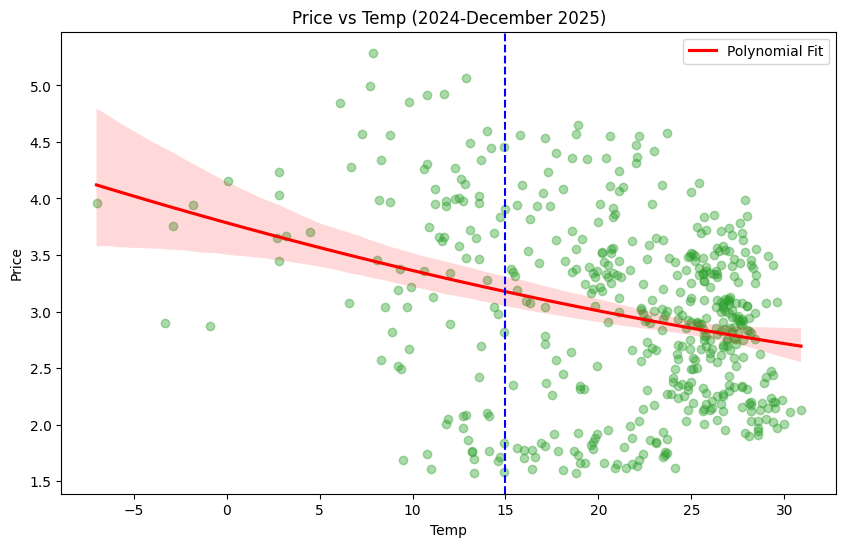

In [12]:
# Filter for data after 2024
recent_data = merged[merged.index >= '2024-01-01']

print(f"Analyzing {len(recent_data)} days of recent data...")

# Recalculate Correlations
corr_pearson = recent_data['Price'].corr(recent_data['Temp'], method='pearson')
corr_spearman = recent_data['Price'].corr(recent_data['Temp'], method='spearman')

print(f"Recent Linear Correlation: {corr_pearson:.2f}")
print(f"Recent Rank Correlation: {corr_spearman:.2f}")

# Re-plot
plt.figure(figsize=(10, 6))
sns.regplot(data=recent_data, x='Temp', y='Price', order=2, 
            scatter_kws={'alpha':0.4, 'color':'#2ca02c'}, 
            line_kws={'color':'red', 'label': 'Polynomial Fit'})

plt.title("Price vs Temp (2024-December 2025)")
plt.axvline(x=15, color='blue', linestyle='--')
plt.legend()
plt.show()

Inverse correlation : We observe a moderate negative correlation in the last two years. Lower temperatures (heating demand) drivce higher prices. Surprisingly though, very high temperature did not drive higher prices (AC demand), which could be due to a robust US Gas supply. 

Limitations: Using Henry Hub (Louisiana) temperature is not a good enough proxy to represent accurately the whole of the US. 

Since the relationship between Gas prices and temperature is noisy, and non linear (for the whole 2020-Today segment), we definetely need to engineer some new features, and use a Non-Linear model like Random Forest. 

## Feature Engineering

Raw financial prices are generally poor inputs for ML models because they're non-stationary. Because of this, data from 2020 might not be really comparable to data from 2025, which will introduce noise. 

So we need to create new, stationary features that capture different aspects of market behavior : 

1. **Trend**: Is the price currently above its 50-day average? (Using `dist_sma_50`).
2.  **Momentum:** Is the asset overbought or oversold? (Using `RSI`).
3.  **Volatility:** Is the market calm or panicking? (Using rolling standard deviation).
4.  **Weather:** Is today's temperature unusual for this time of year? (Using `temp_anomaly`).

Importantly we will implement these calculations using **Vectorized Operations** (Pandas/NumPy).
Vectorization allows us to apply operations to entire columns at once (using underlying C optimization) rather than looping through rows. This reduces computation time drastically, a critical requirement for backtesting optimization. If we want to create a tool that runs in a live testing demo, this is crucial. 

In [13]:
data = merged.copy()

Let's first create a target feature. As mentionned before, raw prices are generally poor inputs for ML models because they're stationary. So we can't simply use the difference in price between "Day n" and "Day n-1". 

We will use log returns instead. 

In [14]:
# 1. Target: Log Returns
data['returns'] = np.log(data['Price'] / data['Price'].shift(1))

# 2. Trend: Distance from Moving Average
data['sma_20'] = data['Price'].rolling(20).mean()
data['sma_50'] = data['Price'].rolling(50).mean()

data['dist_sma_20'] = data['Price'] / data['sma_20'] - 1
data['dist_sma_50'] = data['Price'] / data['sma_50'] - 1

# 3. Momentum: RSI
delta = data['Price'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.ewm(com=13, min_periods=14).mean()
avg_loss = loss.ewm(com=13, min_periods=14).mean()
rs = avg_gain / avg_loss
data['rsi'] = 100 - (100 / (1 + rs))

# 4. Volatility Regime
# Standard deviation of returns over the last month (20 trading days)
data['volatility'] = data['returns'].rolling(20).std()

# 5. Weather Shock (Anomaly)
# Deviation from the recent 30-day norm
data['temp_ma_30'] = data['Temp'].rolling(30).mean()
data['temp_anomaly'] = data['Temp'] - data['temp_ma_30']

# Drop NaNs (start of history)
data.dropna(inplace=True)

print("Features engineered.")
data[['dist_sma_20', 'dist_sma_50', 'rsi', 'volatility', 'temp_anomaly']].tail()

Features engineered.


,dist_sma_20,dist_sma_50,rsi,volatility,temp_anomaly
2025-12-04,0.102378,0.304016,71.673380,0.027826,-3.683333
2025-12-05,0.140018,0.345692,75.379348,0.028562,-8.290000
2025-12-08,0.051989,0.236700,61.034390,0.033961,-5.043333
2025-12-09,-0.022869,0.144072,51.560568,0.038160,-8.110000
2025-12-10,-0.018697,0.141944,52.058474,0.036436,-1.183333


# Walk-Forward Validation

We cannot use a standard random train/test split for time-series analysis because time matters. Unlike traditional cross-validation where data is randomly split, WFV respects the sequence of time, making it ideal for datasets with time-dependent features like stock prices and weather patterns.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Setup Data for ML
# Target: 1 if Returns(t+1) > 0
data['target'] = (data['returns'].shift(-1) > 0).astype(int)

# Select features (No 'Price', no 'Volume')
features = ['dist_sma_20', 'dist_sma_50', 'rsi', 'volatility', 'temp_anomaly']
print(f"Training on: {features}")

# 2. Walk-Forward Loop Parameters
train_window = 365  # Train on 1 year
step = 21           # Retrain every 3 weeks
total_rows = len(data) - 1 # Exclude last row (no target)

predictions = []

# Cursor points to the start of the Test period
cursor = train_window

print("Starting simulation...")
while cursor < total_rows:
    # Define Windows
    train_end = cursor
    test_end = min(cursor + step, total_rows)
    
    # Train
    X_train = data.iloc[:train_end][features]
    y_train = data.iloc[:train_end]['target']
    
    # Test (The next month)
    X_test = data.iloc[train_end:test_end][features]
    y_test = data.iloc[train_end:test_end]['target']
    dates = data.index[train_end:test_end]
    
    # Model (Random Forest)
    model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict
    preds = model.predict(X_test)
    
    # Store
    for d, p, y in zip(dates, preds, y_test):
        predictions.append({'date': d, 'pred': p, 'actual': y})
        
    cursor += step

# 3. Analyze Results
res_df = pd.DataFrame(predictions).set_index('date')
acc = accuracy_score(res_df['actual'], res_df['pred'])
print(f"Walk-Forward Accuracy: {acc:.2%}")

res_df.head()

Training on: ['dist_sma_20', 'dist_sma_50', 'rsi', 'volatility', 'temp_anomaly']
Starting simulation...
Walk-Forward Accuracy: 49.91%


,pred,actual
date,,
2021-08-24,1,1
2021-08-25,1,1
2021-08-26,0,1
2021-08-27,0,0
2021-08-30,0,1


Our Walk-Forward Accuracy is pretty low, but accuracy is not everything. We need to take a look at profit and loss. In this project I have created a binary target, to predict whether the prices will go up or down. But maybe our model managed to catch some big profits while only suffering small losses. This is why we need to plot an equity curve. 

## The Equity Curve

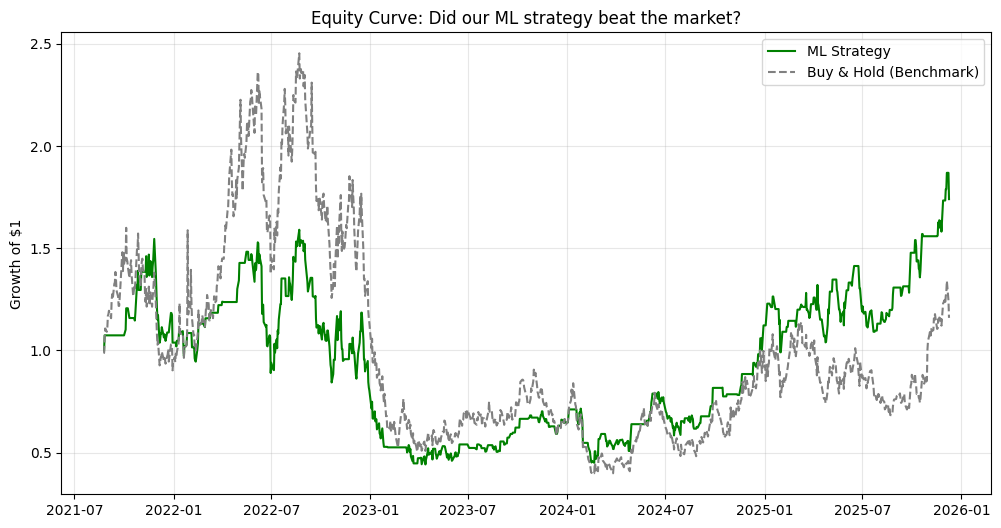

Total Strategy Return: 74.04%
Total Benchmark Return: 15.94%


In [16]:
# 1. Align Predictions with Returns
# Note: Prediction at date T is for the movement T to T+1. 
# But in our dataframe, 'returns' at T is (Price_T / Price_T-1).
# So we need to match: Pred(T-1) * Returns(T).
# Fortunately, our res_df index is the date of the 'actual' target. 
# The target at date T was "Will T+1 be Up?".
# So we simply join on index.

performance = res_df.join(data['returns'], how='left')

performance['simple_returns'] = np.exp(performance['returns']) - 1

# 2. Calculate Strategy Returns
# If Pred=1 (Long), we get the return. If Pred=0, we get 0.
performance['strategy_ret'] = performance['pred'].shift(1) * performance['simple_returns']
performance['benchmark_ret'] = performance['simple_returns']

# 3. Cumulative Returns (Equity Curve)
performance['Strategy Equity'] = (1 + performance['strategy_ret']).cumprod()
performance['Benchmark Equity'] = (1 + performance['benchmark_ret']).cumprod()

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(performance['Strategy Equity'], label='ML Strategy', color='green')
plt.plot(performance['Benchmark Equity'], label='Buy & Hold (Benchmark)', color='gray', linestyle='--')
plt.title("Equity Curve: Did our ML strategy beat the market?")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KPI
total_return = performance['Strategy Equity'].iloc[-1] - 1
print(f"Total Strategy Return: {total_return:.2%}")

benchmark_total_return = performance['Benchmark Equity'].iloc[-1] - 1
print(f"Total Benchmark Return: {benchmark_total_return:.2%}")

## Was the weather feature useful at all ? 

At this point, we can wonder : did our weather feature help us get an edge over the market ? A neat feature of the Random Forest Classifier is that we can ask it which features were the most important. It's like asking it : "which features did you use the most to make decisions ?"

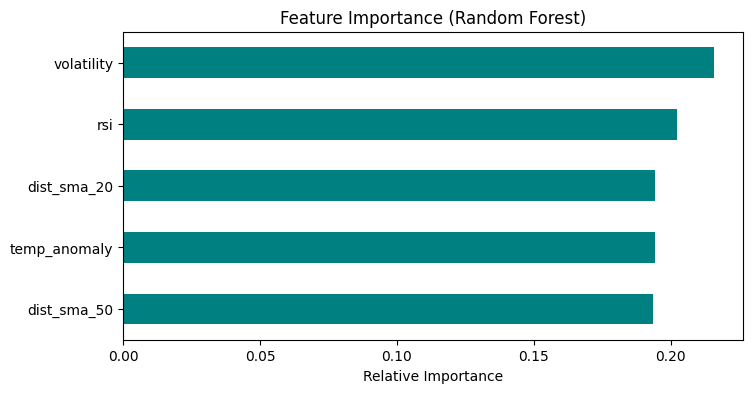

In [17]:
# Get Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 4))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Relative Importance")
plt.show()

Contrary to the weak linear correlation observed in the EDA phase, the **Feature Importance** analysis reveals that `temp_anomaly` is a good predictor. 
This proves that the Random Forest successfully captured the non-linear relationship between weather shocks and price action. 